# CNN Cancer Detection Kaggle Mini-Project
By Wei Yu (David) Wang, DTSA 5511, April 2024

## Introduction

This project focuses on developing a neural network designed to accurately determine whether a body tissue image from a pathology scan is indicative of cancer. This is defined as a binary classification problem, with each image being labeled as cancerous (1) or non-cancerous (0). Here, an image is classified as cancerous if it contains at least one pixel of tumorous tissue.

The dataset utilized in this project is sourced from a [Kaggle competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection). It includes 220,025 labeled training images, with each one designated as either cancerous or not. Additionally, the dataset contains 57,458 unlabeled test images. The primary aim is to engineer a neural network that can effectively predict the labels for these test images. As the test set lacks labels, the network's performance will be assessed by submitting predictions to the aforementioned Kaggle competition.

### Required modules 

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal

from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Loading the data

In [2]:
labels_csv = r'C:\Users\David\Downloads\histopathologic-cancer-detection\train_labels.csv'
data_df = pd.read_csv(labels_csv)

image_dir = r'C:\Users\David\Downloads\histopathologic-cancer-detection\train'
test_dir = r'C:\Users\David\Downloads\histopathologic-cancer-detection\test'

In [3]:
# Dataframe of labels
data_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [4]:
# Data cleaning and preprocessing
# The label needs to be converted into a string type for Keras
# The file extension .tif needs to be added to each id
data_df['label'] = data_df['label'].astype(str)
data_df['id'] = data_df['id'] + '.tif'

Image Shape = (96, 96, 3)


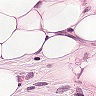

In [5]:
# Examining example image and its structure

example_path = r'C:\Users\David\Downloads\histopathologic-cancer-detection\train\d4b854fe38b07fe2831ad73892b3cec877689576.tif'
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
example_img

From this, we can see that each individual image is at 96 x 96 pixels with 3 values (probably RGB)

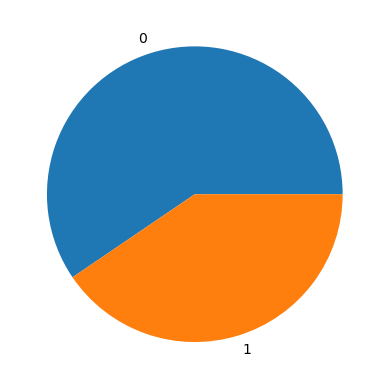

In [6]:
# Pie Chart of Labels 

unique_labels, counts = np.unique(data_df.label.values, return_counts=True)
plt.pie(counts/np.sum(counts), labels=unique_labels)
plt.show()

In [7]:
# Manually viewing cancerous and noncancerous cells

# Examining the data to see if it is potentially possible to manually distinguish cancerous and non-cancerous cells
yes_df = data_df[data_df['label'] == '1']
no_df = data_df[data_df['label'] == '0']

# Randomly sample 10 rows from the filtered DataFrame
random_yes = yes_df.sample(n=30, random_state=42)
lis_yes = random_yes['id'].to_list()
random_no = no_df.sample(n=30, random_state=42)
lis_no = random_no['id'].to_list()

There is a good mixture of cancer and non cancer cells. The dataset does not suffer from a huge imbalance of classes. 

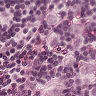

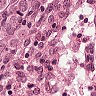

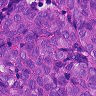

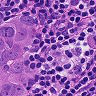

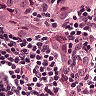

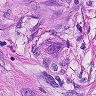

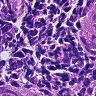

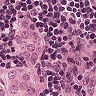

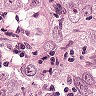

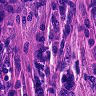

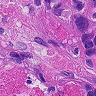

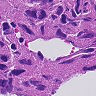

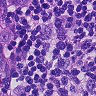

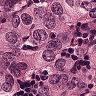

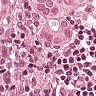

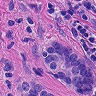

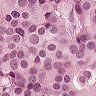

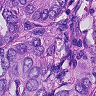

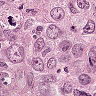

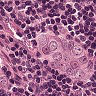

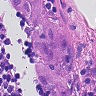

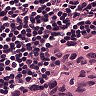

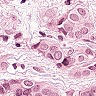

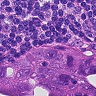

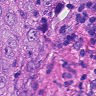

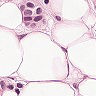

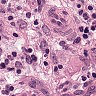

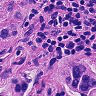

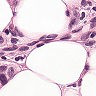

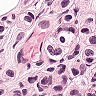

In [8]:
# Viewing cancerous cells

for i in lis_yes:
    example_path = os.path.join(image_dir, i)
    example_img = Image.open(example_path)
    example_array = np.array(example_img)
    # print(f"Image Shape = {example_array.shape}")
    display(example_img)

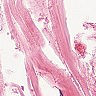

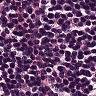

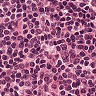

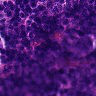

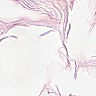

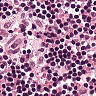

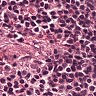

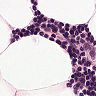

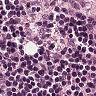

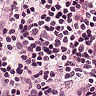

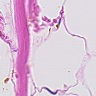

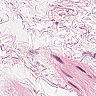

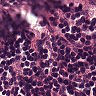

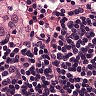

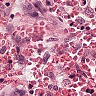

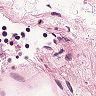

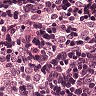

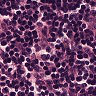

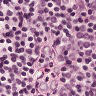

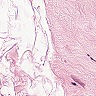

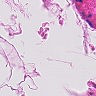

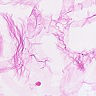

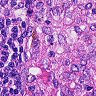

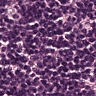

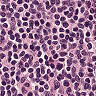

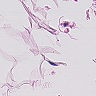

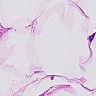

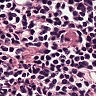

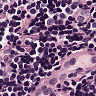

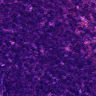

In [9]:
# Viewing non-cancerous cells

for i in lis_no:
    example_path = os.path.join(image_dir, i)
    example_img = Image.open(example_path)
    example_array = np.array(example_img)
    # print(f"Image Shape = {example_array.shape}")
    display(example_img)

Upon viewing these images, I cannot visually distinguish between cancerous and non cancerous cells. This is triggering my trypophobia though. Let's train a neural network to look through these instead.

Based on my EDA, my plan of analysis is to test convolution neural networks with a binary class mode classifier with a sigmoid activation function which outputs a value between 0 and 1, and can be interpreted as the probability of the input belonging to the positive class (often labeled as "1").

## Model Architecture
## Data Preprocessing

The training dataset for this study is extensive, comprising 220,025 images, each with a resolution of 96x96 pixels and three color channels (RGB), summing up to approximately 5.72 gigabytes of data. Given the sheer volume of this dataset, it is impractical to load and store all the data concurrently. Therefore, a **batch loading** technique will be implemented. This technique involves dynamically loading subsets of images into memory in sequential batches during the training process. Each batch is subsequently replaced by the next, ensuring that only one batch of images is maintained in memory at any given time, thereby significantly reducing the memory overhead required for training.

Initially, an `ImageDataGenerator` object will be instantiated to facilitate the preprocessing of these images. The generator will rescale the pixel values to a range of 0 to 1 to normalize the data. Additionally, it will manage the division of the dataset, allocating 80% of the images to training and the remaining 20% to validation.

In [10]:
# Preprocess the images and split the data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train image data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=data_df,
    directory=image_dir,
    x_col='id',  # Column in CSV that contains filenames
    y_col='label',  # Column in CSV that contains labels
    subset="training",
    batch_size=32,
    shuffle=True,
    class_mode="binary",  # Use "categorical" for multi-class classification
    target_size=(96, 96)
)

# validation image data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=data_df,
    directory=image_dir,
    x_col='id',
    y_col='label',
    subset="validation",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(96, 96)
)

# test image data generator

# creating a testing dataframe with only file names
test_ids = [filename[:-4] for filename in os.listdir(test_dir)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["id"] = test_df["id"] + '.tif'
test_df["label"] = None

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col='label',
    subset="validation",
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(96, 96)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 11491 validated image filenames.


In [11]:
# Define a simple CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),  # Reduce the number of filters
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),  # Reduced filters
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),  # Reduced number of neurons in the dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/10
5500/5500 [==============================] - 1190s 216ms/step - loss: 0.4306 - accuracy: 0.8090 - val_loss: 0.3548 - val_accuracy: 0.8506
Epoch 2/10
5500/5500 [==============================] - 405s 74ms/step - loss: 0.3475 - accuracy: 0.8526 - val_loss: 0.3358 - val_accuracy: 0.8583
Epoch 3/10
5500/5500 [==============================] - 422s 77ms/step - loss: 0.3183 - accuracy: 0.8663 - val_loss: 0.3094 - val_accuracy: 0.8713
Epoch 4/10
5500/5500 [==============================] - 420s 76ms/step - loss: 0.2992 - accuracy: 0.8745 - val_loss: 0.3241 - val_accuracy: 0.8642
Epoch 5/10
5500/5500 [==============================] - 420s 76ms/step - loss: 0.2841 - accuracy: 0.8823 - val_loss: 0.3025 - val_accuracy: 0.8767
Epoch 6/10
5500/5500 [==============================] - 426s 77ms/step - loss: 0.2675 - accuracy: 0.8896 - val_loss: 0.3300 - val_accuracy: 0.8687
Epoch 7/10
5500/5500 [==============================] - 417s 76ms/step - loss: 0.2520 - accuracy: 0.8976 - val_loss:

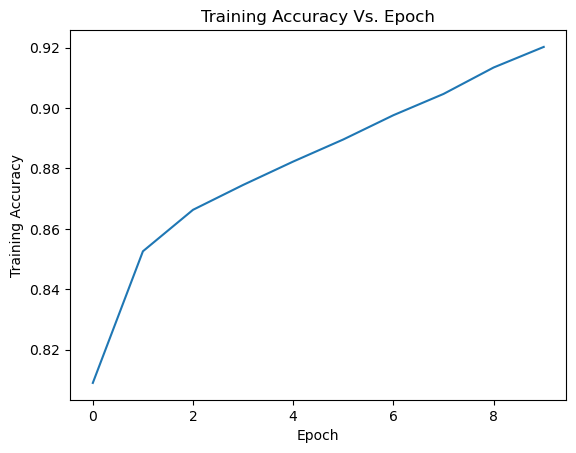

In [13]:
testAccs = history.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
plt.plot(epochs, testAccs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch")
plt.show()

## Convolutional Neural Network (CNN) Model Explanation

### Conv2D Layers
First Conv2D Layer (Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))):
  - 16 Filters: Starts with fewer filters to capture essential features and mitigate overfitting by reducing model complexity and computational demand.
  - Kernel Size (3x3): A standard choice to effectively capture spatial features like edges and textures, balancing complexity and computational efficiency.
  - ReLU Activation: Introduces non-linearity, helping the model learn complex patterns while mitigating the vanishing gradient problem.

Second Conv2D Layer (Conv2D(32, (3, 3), activation='relu')):
  - 32 Filters: Increases the number of filters to detect more complex and varied features after initial simpler patterns have been identified.
  - Consistent Use of 3x3 Kernels and ReLU: Maintains architectural consistency, enabling the network to build upon previously extracted features without excessive complexity.

### Pooling Layers
MaxPooling2D(2, 2): Reduces the spatial dimensions of feature maps, decreasing parameter count and computation, which helps control overfitting and enhances feature robustness.

### Dense Layers and Dropout
Dense(128, activation='relu'):
  - 128 Neurons: Balances learning capability and computational efficiency, serving as a decision-making layer to interpret combined features for predictions.
  - ReLU Activation: Continues to provide non-linearity, essential for complex pattern recognition.

- Dropout(0.5):
  - 50% Dropout Rate: Regularizes the network by randomly ignoring half of the neurons in the previous layer during training, promoting the learning of robust features.

### Output Layer
Dense(1, activation='sigmoid'): Uses a sigmoid activation function to perform binary classification, outputting a probability that indicates likelihood of the input belonging to the positive class.

### Overall Architecture
The architecture is designed to be shallow yet effective, with a careful increment in complexity, suitable for medium-sized datasets and balancing between model complexity and the risk of overfitting. This setup aims to efficiently learn from image data by progressively abstracting from simple to more complex features, concluding with a binary classification decision.

A more complex model can potentially improve results. 

In [14]:
# More complex CNN model

modelc = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
modelc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
historyc = modelc.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/20
5500/5500 [==============================] - 824s 150ms/step - loss: 0.4451 - accuracy: 0.8004 - val_loss: 0.3715 - val_accuracy: 0.8398
Epoch 2/20
5500/5500 [==============================] - 812s 148ms/step - loss: 0.3761 - accuracy: 0.8379 - val_loss: 0.3548 - val_accuracy: 0.8533
Epoch 3/20
5500/5500 [==============================] - 810s 147ms/step - loss: 0.3442 - accuracy: 0.8542 - val_loss: 0.3290 - val_accuracy: 0.8615
Epoch 4/20
5500/5500 [==============================] - 802s 146ms/step - loss: 0.3182 - accuracy: 0.8665 - val_loss: 0.3400 - val_accuracy: 0.8575
Epoch 5/20
5500/5500 [==============================] - 802s 146ms/step - loss: 0.2937 - accuracy: 0.8768 - val_loss: 0.3189 - val_accuracy: 0.8657
Epoch 6/20
5500/5500 [==============================] - 795s 145ms/step - loss: 0.2699 - accuracy: 0.8882 - val_loss: 0.3437 - val_accuracy: 0.8614
Epoch 7/20
5500/5500 [==============================] - 804s 146ms/step - loss: 0.2442 - accuracy: 0.9002 - val_

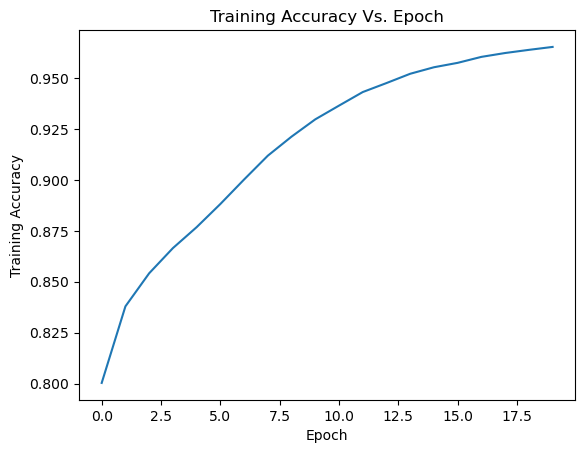

In [16]:
testAccs = historyc.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
plt.plot(epochs, testAccs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch")
plt.show()

In [17]:
# Initialize the model
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Flatten the output to feed into a DNN
model.add(Flatten())

# Dense layer
model.add(Dense(256, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 45, 64)       

In [19]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Ensure model sees all samples
    epochs=10,  # Adjust epochs according to your needs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Same for validation samples
)


Epoch 1/10
5500/5500 [==============================] - 1242s 225ms/step - loss: 0.4232 - accuracy: 0.8269 - val_loss: 0.4163 - val_accuracy: 0.8421
Epoch 2/10
5500/5500 [==============================] - 1254s 228ms/step - loss: 0.3428 - accuracy: 0.8596 - val_loss: 0.3021 - val_accuracy: 0.8831
Epoch 3/10
5500/5500 [==============================] - 1255s 228ms/step - loss: 0.3113 - accuracy: 0.8742 - val_loss: 0.2674 - val_accuracy: 0.8887
Epoch 4/10
5500/5500 [==============================] - 1245s 226ms/step - loss: 0.2855 - accuracy: 0.8853 - val_loss: 0.3093 - val_accuracy: 0.8859
Epoch 5/10
5500/5500 [==============================] - 1252s 228ms/step - loss: 0.2699 - accuracy: 0.8935 - val_loss: 0.3640 - val_accuracy: 0.8673
Epoch 6/10
5500/5500 [==============================] - 1266s 230ms/step - loss: 0.2550 - accuracy: 0.9008 - val_loss: 1.2267 - val_accuracy: 0.7546
Epoch 7/10
5500/5500 [==============================] - 1257s 229ms/step - loss: 0.2452 - accuracy: 0.9055

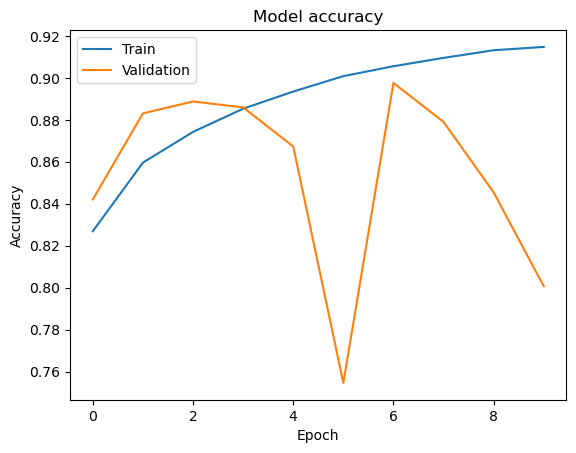

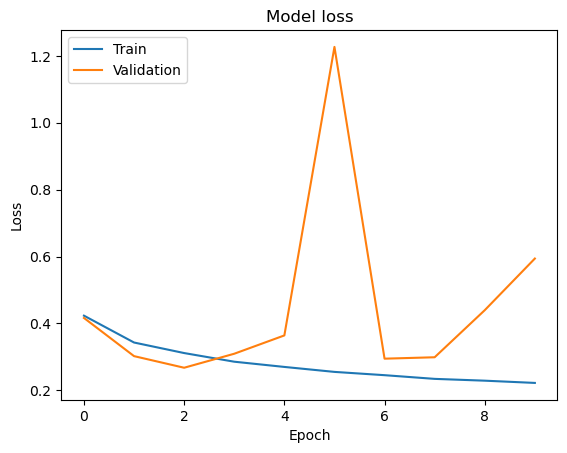

In [20]:
# Validation Plots

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Results and Analysis

## Hyperparameter Tuning Procedure

A function build_model() was created to be used with the function [RandomSearch()](https://keras.io/api/keras_tuner/tuners/random/) that random searches for the most optimal hyperparameter tuning instead of a grid search.

Like its name, RandomSearch involves randomly selecting combinations of hyperparameters to find the best possible model. It does not exhaustively search all parameter combinations, but rather samples them from a specified distribution. Training a neural network is time consuming and using fewer iterations to find a good set of hyperparameters can stumple on to high-performing areas of parameter space more quickly. 

In [21]:

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(96, 96, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Set more trials for a more thorough search
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

Reloading Tuner from my_dir\hparam_tuning\tuner0.json


In [30]:
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=3,
)

Trial 4 Complete [04h 39m 18s]
val_accuracy: 0.8745369911193848

Best val_accuracy So Far: 0.8745369911193848
Total elapsed time: 22h 15m 09s


In [31]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best found hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Print out the best model's architecture
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 batch_normalization_2 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 160)       46240     
                                                                 
 batch_normalization_3 (Bat  (None, 44, 44, 160)      

## Results

Initially, I wanted to run many different trials but later found out that each trial took over 4 ours. 3 trials were setup with the best validation accuracy at 0.875 which is a significant improvement compared to my first model above. 

The tuned hyperparameter model has 3 convolutional layers with increasing filters (32, 64, 128) and uses max pooling and dropout regularly to prevent overfitting. The original model only had 2 convolutional layers. 

The tuned hyperparameter model had more than 29 million parameters whereas the original had only approximately 3 million parameters. 

However, if the simpler model had less iterations in terms of epochs, it would have performed better than the tuned 3 layer models and use less computing power. It seems like with such a large training dataset, the maximum epochs set should only be around 3 to avoid overfitting. 

| Model Name              | Validation Accuracy | Number of Parameters | Number of Convolutional Layers |
|-------------------------|---------------------|----------------------|-------------------------------|
| Simple Model            | 0.80                | 3,371,457            | 2                             |
| Hyperparameter Tuned 1  | 0.875               | 29,787,169           | 3                             |
| Hyperparameter Tuned 2  | 0.835               | 29,021,033           | 3                             |
| Hyperparameter Tuned 3  | 0.785               | 23,363,552           | 3                             |

Making Predictions for Kaggel

In [38]:
from PIL import Image

def prepare_image(image_path):
    # Open the image file
    img = Image.open(image_path)
    # Resize image to match the model's expected input size
    # Convert image to numpy array
    img_array = np.array(img)
    # Normalize the image data to 0-1 range if needed
    img_array = img_array / 255.0
    # Expand dimensions to match model's input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
folder_path = r'C:\Users\David\Downloads\histopathologic-cancer-detection\test'  # Adjust the path to your folder
predictions = []

for filename in os.listdir(folder_path):
    if filename.endswith('.tif'):
        image_path = os.path.join(folder_path, filename)
        img_array = prepare_image(image_path)
        # Predict and take the class with the highest probability
        prediction = best_model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predictions.append((filename, predicted_class))

1/1 [==============================] - 0s 56ms/step


In [ ]:
df = pd.DataFrame(predictions, columns=['id', 'label'])
# Save DataFrame to CSV
df.to_csv('predictions.csv', index=False)

# Conclusion

With so much training data, it seems like reducing the number of iterations in epochs should be kept minimal at 2-3. Adding an additional convolution layer significantly increases the number of parameters (3 million to 30 million) and does not neccessarily improve validation accuracy. What helps improve the performance of the model seems to be keeping the final layer set with a sigmoid activation

An improvement that could be tested in the future is adding in data augmentation. Data augmentation artificially expands the size and diversity of your training dataset by applying random, yet realistic, transformations to the training images. This can include rotations, translations, scaling, flips, and changes in brightness or contrast. This helps prevent overfitting and makes the model robust to variations in new images.

Another improvement could be encorporating advanced loss functions such as weighted cross-entropy whuch can help deal with class imbalance issues.